## Introduction

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import sympy

import torch
from torch import tensor
import torch.nn.functional as F

from fastai.data.transforms import RandomSplitter

In [2]:
# First part is about building a Linear Model for the Kaggle Titanic competition.
path = Path('titanic')

np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

## Cleaning the data

In [3]:
# Import the training dataset into a dataframe
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
# Check for empty cells
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
# See the 'mode' (most common value) of every column
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [6]:
# Replace NaNs with their modes
df.fillna(modes, inplace=True)

# We could also create a new 'boolean' column with 1 when we have a missing value
# e.g. for the Cabin,
# which could potentially be a good predictor

In [7]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [8]:
# See a description of the numerical data
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<Axes: >

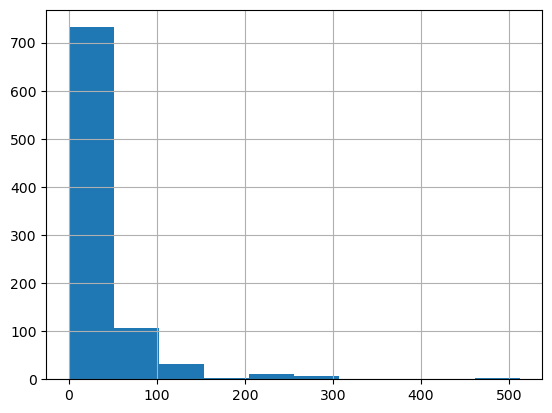

In [9]:
# Usually money data have long tale distributions, mostly low values and very few very high values
# Linear models and NNs do not like these distributions
df['Fare'].hist()

In [10]:
# We use a log to normalize the 'Fare' column
df['LogFare'] = np.log(df['Fare']+1)

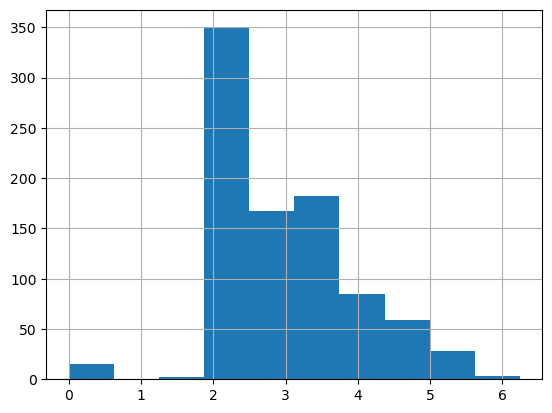

In [11]:
df['LogFare'].hist();

In [12]:
# This is a categorical variable
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

In [13]:
# See a description of the non-numerical data
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [14]:
# Create dummy variables for the categorical variables
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [15]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,True,False,False,False,True,False,False,True
1,False,True,True,False,False,True,False,False
2,False,True,False,False,True,False,False,True
3,False,True,True,False,False,False,False,True
4,True,False,False,False,True,False,False,True


In [16]:
# Turn the dependent variable into a vector (PyTorch 1D Tensor)
t_dep = tensor(df.Survived)

In [17]:
# Gather all the correct independent variables columns
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols

# And create a matrix (a 2D tensor).
# Actually for tensors we use the temr Rank, so this is a Rank 2 tensor.
t_indep = tensor(df[indep_cols].values.astype(float), dtype=torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [18]:
t_indep.shape

torch.Size([891, 12])

## Setting up a linear model

In [19]:
# We will randomize the starting weights (coefficients)
# We do not need a constant as we kept all of the dummy variables columns (did not delete one of them)
# Seed is not needed in rel world applications, as we want to test many times to observe the variations
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [20]:
# Let's what happens if we multiply the independent tensor with the coefficient tensor
# Using bradcasting, pytorch multiplies each of the 12 coefficients with each of the 12 values of every row
# This happens extremely fast, as pytorch is written in C
t_indep*coeffs

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.2632,  -0.0000,   0.0000

In [21]:
# We see that numbers between columns vary
# So we will normalize all colums by dividing each value by its row max
vals,indices = t_indep.max(dim=0)
t_indep = t_indep / vals

In [22]:
# Let's see the normalized results
t_indep*coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

In [23]:
# We sum every column after multiplying to get the predictions
preds = (t_indep*coeffs).sum(axis=1)

In [24]:
preds[:10]

tensor([ 0.1927, -0.6239,  0.0979,  0.2056,  0.0968,  0.0066,  0.1306,  0.3476,  0.1613, -0.6285])

In [25]:
# We will need a loss in order to do Gradient Descent
# We will use the mean absolute value as a loss function
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.5382)

In [26]:
# Let's create the previous 2 steps as functions
def calc_preds(coeffs, indeps):
    return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps):
    return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

## Doing a gradient descent step

In [27]:
# We declare that we need derivatives for the coefficients in order to do Gradient Descent
# The '_' at the end tells us that this WILL change the coeffs values in place
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [28]:
# We will store the Gradient Function as an object
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5382, grad_fn=<MeanBackward0>)

In [29]:
# We execute the loss function backwards (backwards propagation)
loss.backward()

In [30]:
# And this creates a .grad attribute with the coefficients gradients
coeffs.grad

tensor([-0.0106,  0.0129, -0.0041, -0.0484,  0.2099, -0.2132, -0.1212, -0.0247,  0.1425, -0.1886, -0.0191,  0.2043])

In [31]:
# We will subtract the gradient with the learning rate (0.1 in our case)
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5197)


## Training the linear model

In [32]:
# We split the original dataframe (it also has the categorical dummy columns) into a training and a validation set
# This is a fastai command that returns 2 lists with ids
trn_split,val_split=RandomSplitter(seed=42)(df)

In [33]:
trn_split

(#713) [788,525,821,253,374,98,215,313,281,305...]

In [34]:
val_split

(#178) [303,778,531,385,134,476,691,443,386,128...]

In [35]:
# We use the ids to create the actual splits for the independent and dependent variables
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(713, 178)

In [36]:
# Create a function to update the coefficients 
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    # coeffs.grad.zero_()

In [37]:
# Create a function for the backward propagation, essentially an Epoch
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [38]:
# Create a function to add the Gradient Descent to the coefficients
def init_coeffs():
    return (torch.rand(n_coeff)-0.5).requires_grad_()

In [39]:
# Create the function that will train the model and calls all other functions
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs):
        one_epoch(coeffs, lr=lr)
    return coeffs

In [40]:
# Train the model and see the loss of each Epoch
coeffs = train_model(18, lr=0.02)

0.536; 0.532; 0.525; 0.515; 0.503; 0.489; 0.477; 0.466; 0.449; 0.424; 0.396; 0.373; 0.354; 0.338; 0.321; 0.306; 0.297; 0.295; 

In [41]:
# Create a function to show the coefficients, also remove the Gradient Descent from the coefficients
# The smaller the number, the less chance to survive (males and older people)
# We also see that 1st class passengers had a huge chance to survive...
def show_coeffs():
    return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.2335),
 'SibSp': tensor(0.1025),
 'Parch': tensor(0.2530),
 'LogFare': tensor(0.1073),
 'Sex_male': tensor(-0.4166),
 'Sex_female': tensor(0.3314),
 'Pclass_1': tensor(0.8639),
 'Pclass_2': tensor(0.4225),
 'Pclass_3': tensor(0.2875),
 'Embarked_C': tensor(0.1840),
 'Embarked_Q': tensor(0.3267),
 'Embarked_S': tensor(0.1158)}

## Measuring accuracy

In [48]:
# Let's fit the model to our validation dataset to get the predictions on who survived
# We create a rank 1 tensor of probabilities (actually the range is -0.11 : 1.52)
# (indeps*coeffs).sum(axis=1)
preds = calc_preds(coeffs, val_indep)
preds


tensor([ 1.0550,  0.1648,  0.0210,  0.1432,  0.0940,  0.0883,  0.8792,  0.8332,  0.1986,  0.8419, -0.0691,  0.0877,  0.0729,  0.9130,
        -0.0780,  0.4887,  0.4303,  0.8954,  0.0644,  0.6831, -0.0458,  0.4566,  1.4014,  0.8986, -0.0359,  0.1958,  0.8296,  0.4391,
        -0.0240,  0.9128,  0.9467,  0.9028, -0.0312, -0.0645,  1.0375,  0.9240,  0.4870,  1.3822, -0.0455,  0.7121,  0.1081, -0.0455,
         0.1561,  1.3605, -0.0339,  0.8894, -0.0196,  0.0162,  0.1632,  0.7067,  0.7487,  0.1752,  0.1557, -0.0505,  0.0877,  0.0702,
         0.1648, -0.0574, -0.0368, -0.0477,  0.6014, -0.0143,  0.3885, -0.0370,  0.8106,  0.6189,  0.0969, -0.0718,  0.1840,  0.7842,
        -0.0517,  0.8650,  0.0731, -0.0430,  0.5496, -0.0227, -0.0455,  0.5425,  0.1115,  0.0321,  0.2499,  1.5236, -0.0429, -0.0471,
         0.7656,  0.2785,  0.6723,  1.4497,  0.9242,  0.0999, -0.0683, -0.0455,  1.3720,  0.0035,  0.9201,  0.1299,  0.0440,  0.9559,
         0.9186,  0.1773,  0.0266,  0.9128, -0.0692, -0.0634, 

In [79]:
pd.DataFrame(preds).describe()

,0
count,178.000000
mean,0.451564
std,0.480758
min,-0.109018
25%,-0.002601
50%,0.228926
75%,0.839885
max,1.523621


In [43]:
# Compare the predictions with the actual validation data
results = val_dep.bool()==(preds>0.5)
results[:16]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True, False])

In [54]:
# Our actual accuracy
results.float().mean()

tensor(0.7921)

In [53]:
# Create a function for the above to calculate the accuracy
def acc(coeffs):
    return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.7921)

## Using sigmoid

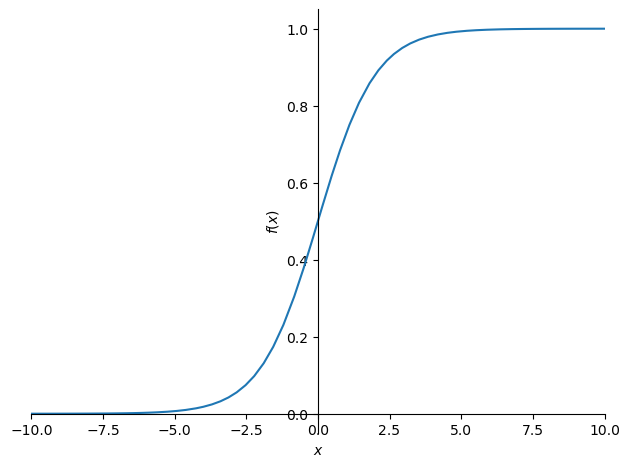

In [56]:
# This is the sigmoid function
# SymPy is the Symbolic Math Python library
sympy.plot("1/(1+exp(-x))", xlim=(-10,10));

In [57]:
# We redefine the predictions function by putting them through the PyTorch Sigmoid function
def calc_preds(coeffs, indeps):
    return torch.sigmoid((indeps*coeffs).sum(axis=1))

In [62]:
# We re-train the model
coeffs = train_model(lr=100)

0.510; 0.327; 0.325; 0.321; 0.294; 0.271; 0.249; 0.215; 0.214; 0.214; 0.212; 0.210; 0.208; 0.208; 0.208; 0.208; 0.208; 0.208; 0.207; 0.207; 0.206; 0.204; 0.197; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 

In [63]:
# See the new accuracy
acc(coeffs)

tensor(0.8258)

In [64]:
# and the coefficients
show_coeffs()

{'Age': tensor(-33.7117),
 'SibSp': tensor(-6.6112),
 'Parch': tensor(7.2462),
 'LogFare': tensor(20.2563),
 'Sex_male': tensor(-300.2455),
 'Sex_female': tensor(234.5510),
 'Pclass_1': tensor(106.6401),
 'Pclass_2': tensor(26.3491),
 'Pclass_3': tensor(-197.0247),
 'Embarked_C': tensor(26.1838),
 'Embarked_Q': tensor(-7.7948),
 'Embarked_S': tensor(-83.3719)}

## Submitting to Kaggle

In [72]:
# Let's try it on the test dataset
tst_df = pd.read_csv(path/'test.csv')

In [73]:
# Pre-Processing
tst_df['Fare'] = tst_df.Fare.fillna(0)

In [74]:
tst_df.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype='object')

In [75]:
tst_df.fillna(modes, inplace=True)
tst_df['LogFare'] = np.log(tst_df['Fare']+1)

tst_df = pd.get_dummies(tst_df, columns=["Sex","Pclass","Embarked"])

# Normalization
tst_indep = tensor(tst_df[indep_cols].values.astype(float), dtype=torch.float)
tst_indep = tst_indep / vals

In [76]:
# Fit, predict and add as 'Survived' column
tst_df['Survived'] = (calc_preds(tst_indep, coeffs)>0.5).int()

In [77]:
# Save
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

# This is the end of the Titanic Kaggle competition part

## Using matrix product

In [80]:
# These 2 lines of code are exactly the same
# This is the Python way
(val_indep*coeffs).sum(axis=1)

tensor([ 251.4031, -508.1430, -474.3590, -350.8619, -359.2377, -362.3896,   71.8931,  174.2947, -570.2220,   64.2050, -587.0224, -471.7701,
        -573.8452,   26.7057, -588.4316, -285.1774, -293.6053,  178.8983, -363.0055,  -51.5398, -583.6619, -289.8127,  366.6333,  172.4886,
        -582.3005, -505.5379,  -37.7845, -292.3411, -580.4437,   26.6582,  180.9241,  -41.7465, -581.5549, -586.3452,  248.8747,  -36.3020,
        -285.2414,  371.0647, -583.6061,  -50.1025, -357.3477, -583.6061, -359.5366,  368.0013, -581.9205,  -45.0559, -578.4477, -579.4805,
        -508.4496,  -48.2672, -206.9535, -573.5933, -574.0370, -584.4075, -360.2975, -362.8259, -508.1384, -587.5300, -582.3419, -583.4370,
        -169.1624, -581.8611, -299.5433, -582.3870,  168.8577, -270.4664, -358.8163, -586.6096, -512.4406,  167.2449, -584.5046,   65.0605,
        -362.4045, -583.1237, -276.4026, -580.3351, -583.6061, -279.1758, -356.7093, -368.0750, -346.1618,  377.3784, -583.2405, -583.9065,
         164.3855, -

In [81]:
# This is the PyTorch way
val_indep@coeffs

tensor([ 251.4031, -508.1430, -474.3590, -350.8618, -359.2376, -362.3896,   71.8931,  174.2947, -570.2220,   64.2050, -587.0224, -471.7701,
        -573.8453,   26.7057, -588.4316, -285.1774, -293.6053,  178.8983, -363.0055,  -51.5398, -583.6619, -289.8127,  366.6333,  172.4886,
        -582.3005, -505.5379,  -37.7845, -292.3411, -580.4438,   26.6582,  180.9241,  -41.7465, -581.5549, -586.3452,  248.8747,  -36.3020,
        -285.2414,  371.0647, -583.6061,  -50.1025, -357.3477, -583.6061, -359.5366,  368.0013, -581.9205,  -45.0559, -578.4477, -579.4805,
        -508.4496,  -48.2672, -206.9535, -573.5933, -574.0370, -584.4075, -360.2975, -362.8259, -508.1384, -587.5300, -582.3419, -583.4371,
        -169.1624, -581.8611, -299.5433, -582.3870,  168.8577, -270.4664, -358.8163, -586.6096, -512.4406,  167.2449, -584.5046,   65.0605,
        -362.4045, -583.1237, -276.4025, -580.3351, -583.6061, -279.1758, -356.7093, -368.0750, -346.1618,  377.3784, -583.2405, -583.9065,
         164.3855, -

In [82]:
# So we redefine the calc_pred function
def calc_preds(coeffs, indeps):
    return torch.sigmoid(indeps@coeffs)

In [83]:
# Let's initialize the coefficients, but this time instead of a vector we will create a n by 1 matrix
def init_coeffs():
    return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

In [84]:
# We will convert the dependent variable vectors of the datasets into the same n by 1 size tensors
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

In [85]:
val_dep

tensor([[1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],

In [86]:
coeffs = train_model(lr=100)

0.512; 0.323; 0.323; 0.315; 0.276; 0.262; 0.222; 0.215; 0.214; 0.214; 0.213; 0.211; 0.209; 0.208; 0.208; 0.208; 0.208; 0.208; 0.208; 0.207; 0.207; 0.206; 0.204; 0.197; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 

In [88]:
coeffs.shape

torch.Size([12, 1])

In [87]:
acc(coeffs)

tensor(0.8258)

## A neural network

In [92]:
# We will now create an actual NN
def init_coeffs(n_hidden=20):
    # 12 by 20 matrix, the /n_hidden is a trick to get the model to train (coeffs were too big)
    # This set of coeffs goes from input to hidden
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden
    # Again, the -0.3 is a trick to get the model to train (found by trial and error)
    # This set of coeffs goes from hidden to a single output
    layer2 = torch.rand(n_hidden, 1)-0.3
    # Layer 2 needs a constant term (column)
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

In [93]:
# This is our NN
def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

In [94]:

def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)

In [98]:
coeffs = train_model(lr=1.4)

0.543; 0.532; 0.509; 0.467; 0.396; 0.315; 0.271; 0.239; 0.213; 0.206; 0.208; 0.210; 0.211; 0.209; 0.203; 0.193; 0.192; 0.192; 0.192; 0.192; 0.192; 0.193; 0.194; 0.193; 0.191; 0.191; 0.192; 0.192; 0.192; 0.192; 

In [99]:
acc(coeffs)

tensor(0.8258)

## Deep learning

In [100]:
# We will recreate the functions so we can have as many layers with as many coefficients we want
def init_coeffs():
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts:
        l.requires_grad_()
    return layers,consts

In [101]:
def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        # For all layers except the last we use Relu and for the last we use Sigmoid activation functions
        if i!=n-1:
            res = F.relu(res)
    return torch.sigmoid(res)

In [102]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [103]:
coeffs = train_model(lr=4)

0.521; 0.483; 0.427; 0.379; 0.379; 0.379; 0.379; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.377; 0.376; 0.371; 0.333; 0.239; 0.224; 0.208; 0.204; 0.203; 0.203; 0.207; 0.197; 0.196; 0.195; 

In [104]:
acc(coeffs)

tensor(0.8258)